# TP2 Reconstruction of DOSY NMR signals - Part I

* Authors: Mengda Li, Ségolène Martin

## 1 Introduction


Our goal of optimization: find 

$$ \hat{x} = \underset{x \in \mathbb{R}^N}{\arg\min}
\frac{1}{2} \left\lVert Kx - y \right\rVert ^2 + \beta g(x)$$

where $g \in \Gamma_0(\mathbb{R}^N)$ denotes a regularization term and $\beta ≥ 0$.

## 2 Generation of synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp#, log
from math import log
from scipy import linalg
from tqdm.auto import tqdm

T_MIN = 1
T_MAX = 1000
N = 200
M = 50
t_MIN = 0
t_MAX = 1.5

1. Download on the website the diffusion signal  $\bar{x}$

In [2]:
original_signal = np.loadtxt('x.txt')

2. Create $T$ using an exponential sampling strategy

In [3]:
def T_sampling(n):
    return T_MIN * exp(-(n-1)*(log(T_MIN/T_MAX)/(N-1)))

T = T_sampling(np.arange(1, N+1))

3. Display the original signal $\bar{x}$ as a function of $T$ (use log scale on the horizontal axis).

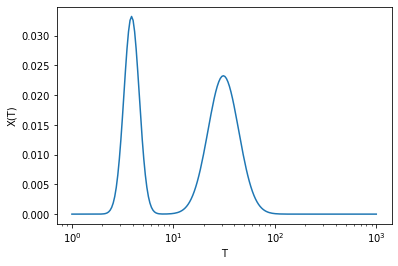

In [4]:
plt.plot(T, original_signal)
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

4. Create $t$ using a regular sampling strategy

In [5]:
def t_sampling(m):
    return t_MIN + (m-1)/(M-1) * (t_MAX - t_MIN)
t = t_sampling(np.arange(1, M+1))

5. Construct matrix $K$

In [6]:
K = exp(-np.tensordot(t, T, axes = 0))

6. Simulate the noisy data $y = K \bar{x} + w$

In [7]:
z = K @ original_signal
sigma = 0.01 * z[0]
I_M = np.identity(M)
cov = sigma**2 * I_M
mean = np.zeros(M)

w = np.random.multivariate_normal(mean, cov)
y = z + w

7. Display the resulting noisy data $y$ as a function of $t$.

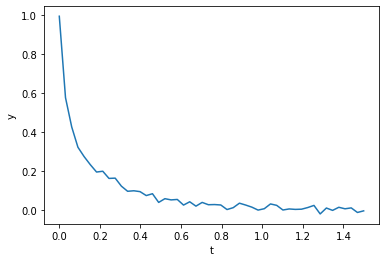

In [8]:
plt.plot(t, y)
plt.ylabel("y")
plt.xlabel('t');

## 3 Comparison of regularization strategies

* ###  Case 1: **Smoothness prior**

$$g(x) = \frac{1}{2} \lVert Dx \rVert^2$$

with $D = 
\begin{pmatrix}
    1       & 0 & 0 & \dots & -1 \\
    -1      & 1 & 0 & \dots & 0 \\
    \vdots & \ddots & \ddots \\
    0       & 0 & \dots &  -1 &1
\end{pmatrix} \in \mathbb{R}^{N \times N}$

We want to minimize the function 

\begin{align}
f(x) &= \frac{1}{2} \left\lVert Kx - y \right\rVert ^2 + 
\beta \frac{1}{2} \lVert Dx \rVert^2 \\
    & =\frac{1}{2} x^T(K^T K + \beta D^T D) x - y^T K x + \frac{1}{2}\|y\|^2
\end{align}

$f$ is differentiable as a sum of two differentiable functions, with $\forall x \in \mathbb{R}^N$, $$\nabla f(x) = (K^T K + \beta D^T D) x - K^T y$$

#### 1. Discuss the existence and uniqueness of a solution to the problem.

It is a **quadratic minimization problem**.

$x \mapsto \Vert Kx -y \Vert^2$ is convex as a composition of the convex function $\Vert . \Vert^2$ with a linear function. For the same reason $x\mapsto \Vert Dx \Vert^2$ is convex. Hence $f$ is convex. Thus there exists a solution to the problem if and only if $\nabla f$ vanishes, that is if and only if $K^Ty \in \text{Im}(K^T K + \beta D^T D)$. 

In that case $\hat{x}$ is a solution if and only if $\nabla f(\hat{x}) =0$. Thus the solution is unique if and only if $K^T K + \beta D^T D$ is invertible, and since $K^T K + \beta D^T D$ is symetric semidefinite, this condition reduces to $ K^T K + \beta D^T D  \succ 0$.

It may be resumed as follows :
* if $(K^T K + \beta D^T D) \succ 0$, then there is a unique solution, 
$$\hat{x} =(K^T K + \beta D^T D)^{-1} K^T y $$

* In the more general case when $K^T K + \beta D^T D$ is not positive definite, any solution of $(K^T K + \beta D^T D) \hat{x} = K^T y$ is optimal

* If $(K^T K + \beta D^T D) \hat{x} = K^T y$ does not have a solution, then the problem is unbounded below.

#### 2. Propose an approach to solve problem

The key is to solve the linear system
$$(K^T K + \beta D^T D) \hat{x} = K^T y \tag{*}$$
&nbsp; &nbsp;&nbsp;&nbsp;if there is a solution $\hat{x}$ for $(*)$, then it is the optimum. 

We can use `scipy.linalg.solve` to solve this system numerically if $(K^T K + \beta D^T D)$ is not singular.

**_Remark_**:
I did a small test of conditional number for the matrix $(K^T K + \beta D^T D)$. The result shows that if $\beta \in ]0, 100]$, the linear system can be solved numerically safely. Here I use `scipy.linalg.solve` which is faster and more stable than `scipy.linalg.inv`.

*The following test code is time-consumming.*

In [12]:
D = np.identity(N)
D[0, -1] = -1
for i in range(1, N):
    D[i, i-1] = -1
  
K_SQUARE = K.T @ K
D_SQUARE = D.T @ D
KY = K.T @ y

DTYPE = (K_SQUARE +  D_SQUARE).dtype

def singularity_test(beta):
    MATRIX = K_SQUARE + beta * D_SQUARE
    return np.linalg.cond(MATRIX) < 1/np.finfo(DTYPE).eps

singularity_test = np.vectorize(singularity_test)

Beta = np.linspace(0, 100, 10000)
test_result = singularity_test(Beta)

singular_index = np.where(test_result == False)
print("when \u03B2 \u2208{}, the matrix is 'singular' numerically".format(Beta[np.where(test_result == False)]))

when β ∈[0.], the matrix is 'singular' numerically


#### 3. Implement it, and display the restored signal $\bar{x}$

We show the restored signal with $\beta = 1, \beta = 10, \beta = 100$ in this question. Unfortunately, we have ill-conditioned matrix in the linear system.

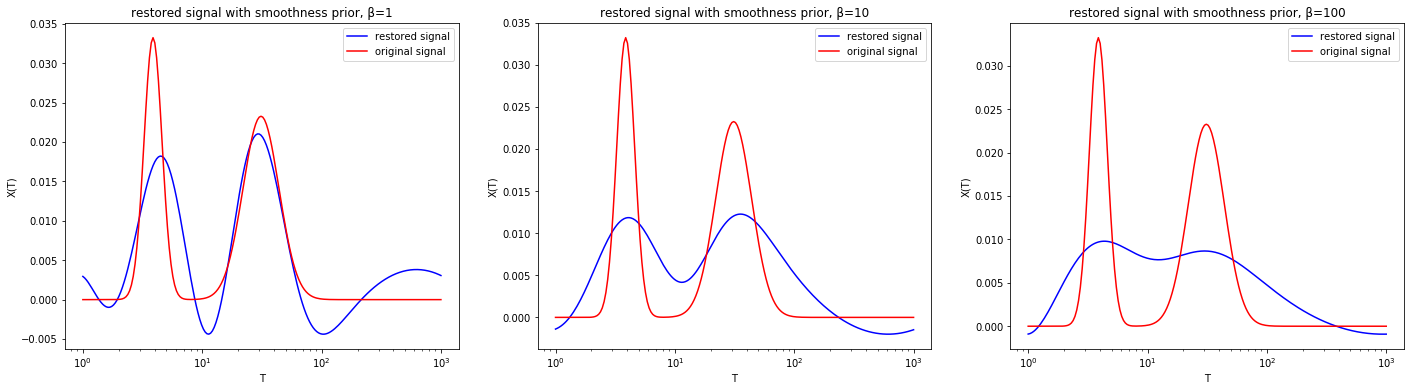

In [9]:
beta = 1

D = np.identity(N)
D[0, -1] = -1
for i in range(1, N):
    D[i, i-1] = -1
  
K_SQUARE = K.T @ K
D_SQUARE = D.T @ D
KY = K.T @ y

plt.rcParams['figure.figsize'] = [24, 6]

plt.figure()
plt.subplot(1, 3, 1)
restored_signal_smooth_1 = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)
plt.plot(T, restored_signal_smooth_1, 'b-', label = "restored signal")
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior, \u03B2={}'.format(beta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 2)
beta = 10
restored_signal_smooth_10 = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)

plt.plot(T, restored_signal_smooth_10, 'b-', label = "restored signal")
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior, \u03B2={}'.format(beta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 3)
beta = 100
restored_signal_smooth_100 = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)

plt.plot(T, restored_signal_smooth_100, 'b-', label = "restored signal")
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior, \u03B2={}'.format(beta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

#### 4. Compute the normalized quadratic error between $\hat{x}$ and $\bar{x}$.

We show the normalized quadratic error with $\beta = 1, \beta = 10, \beta = 100$ in this question.

In [10]:
X_BAR_SQUARE = np.dot(original_signal, original_signal)

def normalized_quadratic_error(restored_signal):
    x_hat_square = np.dot(restored_signal, restored_signal)
    return (x_hat_square -2 * np.dot(original_signal, restored_signal) + X_BAR_SQUARE) / X_BAR_SQUARE

error_smooth_1 = normalized_quadratic_error(restored_signal_smooth_1)
print('error = {:9.8f} with \u03B2={}'.format(error_smooth_1, 1))

error_smooth_10 = normalized_quadratic_error(restored_signal_smooth_10)
print('error = {:9.8f} with \u03B2={}'.format(error_smooth_10, 10))

error_smooth_100 = normalized_quadratic_error(restored_signal_smooth_100)
print('error = {:9.8f} with \u03B2={}'.format(error_smooth_100, 100))

error = 0.20801858 with β=1
error = 0.36520665 with β=10
error = 0.49277900 with β=100


#### 5. When needed, search manually for the best choice for parameter $\beta$ in terms of reconstruction error.

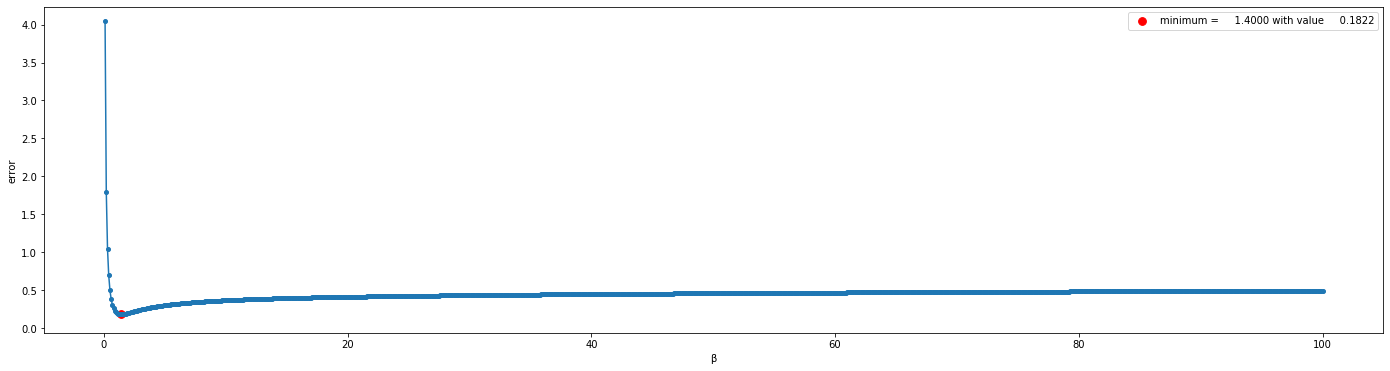

In [11]:
def error_smooth_beta(beta):
    restored_signal_smooth = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)
    error_smooth = normalized_quadratic_error(restored_signal_smooth)
    return error_smooth

error_smooth_beta = np.vectorize(error_smooth_beta)

Beta = np.linspace(0.1, 100, 1000)
Error_smooth = error_smooth_beta(Beta)

plt.plot(Beta, Error_smooth, 'o-', markersize=4)
plt.xlabel('\u03B2')
plt.ylabel('error');

min_index = np.argmin(Error_smooth)
minimum = Beta[min_index]
min_val = Error_smooth[min_index]

plt.scatter(minimum, min_val, s= 60, c = 'red', label = 'minimum = {:10.4f} with value {:10.4f}'.format(minimum, min_val))
plt.legend();

For the best value of $\beta$ found, here is the restored signal :

error = 0.49277900 with β=1.4000000000000001


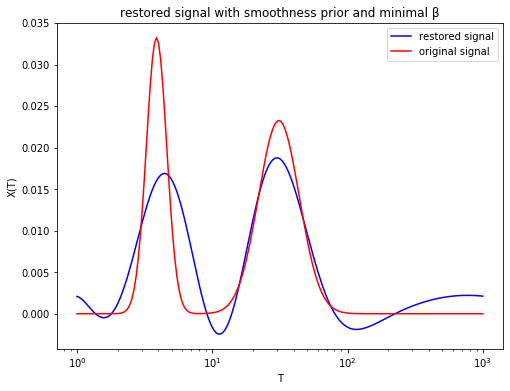

In [12]:
beta = minimum
restored_signal_smooth_100 = linalg.solve(K_SQUARE + beta * D_SQUARE, KY)

plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(T, restored_signal_smooth_100, 'b-', label = "restored signal")
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior and minimal \u03B2'.format(beta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

error_smooth = normalized_quadratic_error(restored_signal_smooth_100)
print('error = {:9.8f} with \u03B2={}'.format(error_smooth_100, beta))

* ###  Case 2: **Smoothness prior + constraints**

$$g(x) = \frac{1}{2} \lVert Dx \rVert^2 + \iota_{[\bar{x}_{min}, \bar{x}_{max}]^N}(x)$$
with $$D = 
\begin{pmatrix}
    1       & 0 & 0 & \dots & -1 \\
    -1      & 1 & 0 & \dots & 0 \\
    \vdots & \ddots & \ddots & \ddots & \vdots \\
    0       & 0 & \dots &  -1 &1
\end{pmatrix} \in \mathbb{R}^{N \times N} \quad \iota_{[\bar{x}_{min}, \bar{x}_{max}]^N}(x) =
  \begin{cases}
    0 & \text{if} \ \bar{x}_{min} <x_i< \bar{x}_{max} \ \forall i \in [1..N] \\
    +\infty & \text{otherwise}
  \end{cases}$$ 
  
Let $f(x) = \frac{1}{2} \left\lVert Kx - y \right\rVert ^2 + \beta g(x)$.
We want to solve the problem :

\begin{align}
\text{argmin}_{x \in \mathbb{R}^N} f(x)
\end{align}

#### 1. Discuss the existence and uniqueness of a solution to the problem.

$f$ is continuous on the compact $[x_{min} , x_{max}]^N$ and take the value $+\infty$ on $\left([x_{min} , x_{max}]^N\right)^c$. So **the problem always has at least one solution** and the solutions lie in $[x_{min} , x_{max}]^N$. Since $f$ is convex and differentiable on $]x_{min} , x_{max}[^N$ with $\nabla f(x) = (K^T K + \beta D^T D) x - K^T y$ :

* If $(K^T K + \beta D^T D) \succ 0$, $f$ is strictly convex on $[x_{min} , x_{max}]^N$. Thus the problem has an unique solution, and the solution may be in $]x_{min} , x_{max}[^N$ or on its border. 
* Otherwise, if $(K^T K + \beta D^T D)$ is not definite positive, nothing can be said about the uniqueness of the minimum.

#### 2. Propose an approach to solve problem

To solve this problem we will be using the **projected gradient method**. Indeed, solving the problem amouts to minimize the function $$h:x \mapsto\frac{1}{2} \left\lVert Kx - y \right\rVert ^2 + \beta \frac{1}{2} \lVert Dx \rVert^2 ~\in \Gamma_0(\mathbb{R}^N)$$ over the closed non-empty convex set $[x_{min} , x_{max}]^N$. First we make the choice of the parameters.

* $\nu$: Lipschitz constant of $\nabla h$.

We have $\nabla h(x) = (K^T K + \beta D^T D) x - K^T y$, so the best $\nu$ that can be chosen is $\nu =\Vert K^T K + \beta D^T D \Vert_2 = \rho (K^T K + \beta D^T D)$ where $\rho$ is the spectral radius. It can be computed with the package `linalg`.

* $\gamma \in [0, 2/\nu]$ and $\delta = 2 - \gamma \nu /2 \in ]1, 2[$.
* $\lambda_n$ a sequence in $[0, \delta]$. For simplicity we choose $\lambda_n = 0.98\times\delta$ for all $n$.
* We need to calculate $P_C$ the projection on the convex $C$. It is clear it is given by : $$P_C(x) =x_{min}\left(1_{|x_i-x_{max}|> |x_i-x_{min}|}1_{x_i \notin [x_{min},x_{max}]}\right)_{i\in [1, N]} + x_{max}\left(1_{|x_i-x_{max}|\leq |x_i-x_{min}|}1_{x_i \notin [x_{min},x_{max}]}\right)_{i\in [1, N]} + \left(x_i 1_{x_i \in [x_{min},x_{max}]}\right)_{i\in [1, N]}$$


#### 3. Implement it, and display the restored signal $\bar{x}$

In [13]:
x_min = np.min(original_signal)
x_max = np.max(original_signal)
def P_C(x):
    if x < x_min:
        return x_min
    elif x > x_max:
        return x_max
    else:
        return x
P_C = np.vectorize(P_C)

def relative_change(x, x_new):
    return linalg.norm(x_new-x) / linalg.norm(x)

def proj_grad(x_0, eps, beta):  

    MATRIX = K_SQUARE + beta * D_SQUARE
    def grad_h(x):
        return MATRIX @ x - KY

    # Parameters
    nu = np.max(np.abs(linalg.eigvals(MATRIX)))
    gamma = (2 / nu) * 0.98
    delta = 2 - gamma*nu/2
    lamb = delta * 0.99
  
    # Initialisation
    x = x_0
    stopping_criteria = 1
    iteration = 0
    MAX_ITER = 1e5
    
    
    # Itération
    while stopping_criteria > eps :
        if iteration > MAX_ITER:
            print('max iteration {} reached'.format(MAX_ITER))
            return x
        
        iteration += 1
        z = x-gamma*grad_h(x)
        x_new = x + lamb*(P_C(z)-x)
        stopping_criteria = relative_change(x, x_new)
        x = x_new

        #if iteration%100 == 0:
            #print('iter = {}, err = {}, norme x = {}'.format(iteration, err,np.linalg.norm(x)))
    
    return x

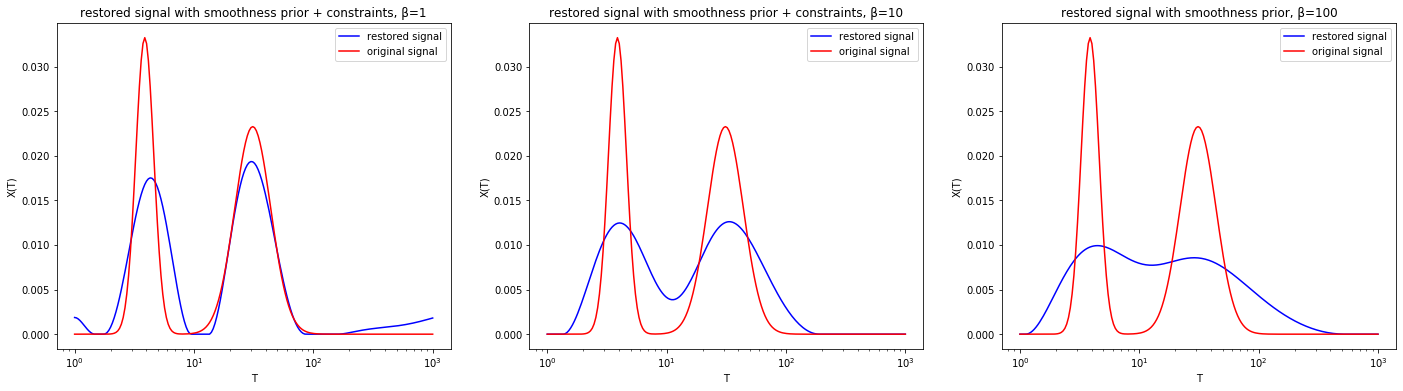

In [15]:
x_0 = original_signal#np.ones(N)*(x_max+x_min)/2
restored_signal_constraint_1 = proj_grad(x_0, 1e-6, 1)
restored_signal_constraint_10 = proj_grad(x_0, 1e-6, 10)
restored_signal_constraint_100 = proj_grad(x_0, 1e-6, 100)


plt.rcParams['figure.figsize'] = [24, 6]

plt.figure()
plt.subplot(1, 3, 1)
plt.plot(T, restored_signal_constraint_1, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior + constraints, \u03B2={}'.format(1))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 2)
plt.plot(T, restored_signal_constraint_10,'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior + constraints, \u03B2={}'.format(10))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 3)
plt.plot(T, restored_signal_constraint_100,'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior, \u03B2={}'.format(100))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

#### 4. Compute the normalized quadratic error between $\hat{x}$ and $\bar{x}$.

We show the normalized quadratic error with $\beta = 1, \beta = 10, \beta = 100$ in this question.

In [16]:
def normalized_quadratic_error(restored_signal):
    x_hat_square = np.dot(restored_signal, restored_signal)
    return (x_hat_square -2 * np.dot(original_signal, restored_signal) + X_BAR_SQUARE) / X_BAR_SQUARE

error_constraint_1 = normalized_quadratic_error(restored_signal_constraint_1)
print('error = {:9.8f} with \u03B2={}'.format(error_constraint_1, 1))

error_constraint_10 = normalized_quadratic_error(restored_signal_constraint_10)
print('error = {:9.8f} with \u03B2={}'.format(error_constraint_10, 10))

error_constraint_100 = normalized_quadratic_error(restored_signal_constraint_100)
print('error = {:9.8f} with \u03B2={}'.format(error_constraint_100, 100))

error = 0.07767074 with β=1
error = 0.17955328 with β=10
error = 0.42162341 with β=100


#### 5. When needed, search manually for the best choice for parameter $\beta$ in terms of reconstruction error.

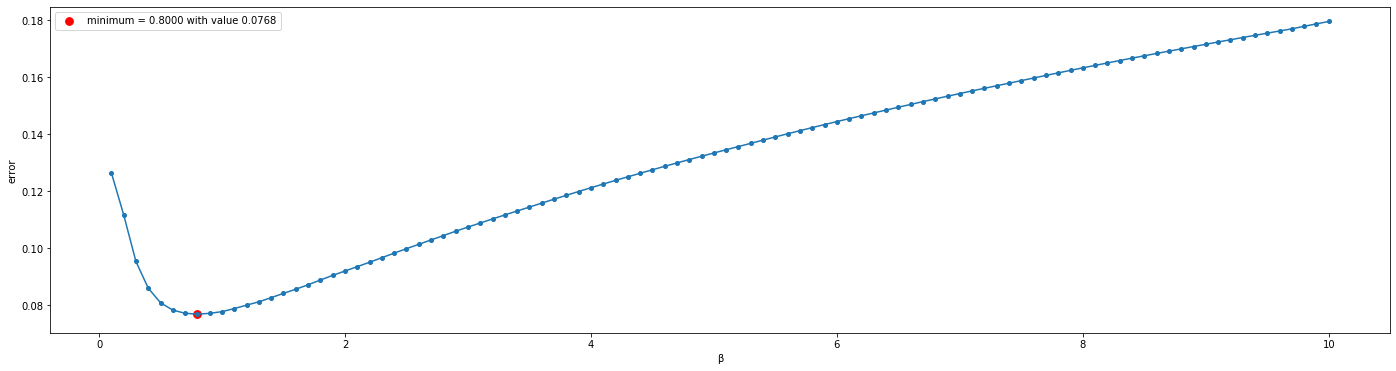

In [17]:
def error_constraint_beta(beta):
    restored_signal_constraint = proj_grad(x_0, 1e-06, beta)
    error_constraint = normalized_quadratic_error(restored_signal_constraint)
    return error_constraint

error_constraint_beta = np.vectorize(error_constraint_beta)

Beta = np.linspace(0.1, 10, 100)
Error_constraint = error_constraint_beta(Beta)

plt.plot(Beta, Error_constraint, 'o-', markersize=4)
plt.xlabel('\u03B2')
plt.ylabel('error');

min_index = np.argmin(Error_constraint)
minimum = Beta[min_index]
min_val = Error_constraint[min_index]

plt.scatter(minimum, min_val, s= 60, c = 'red', label = 'minimum = {:5.4f} with value {:5.4f}'.format(minimum, min_val))
plt.legend();

For the best value of $\beta$ found, here is the restored signal :

error = 0.13770983 with β=1.4000000000000001


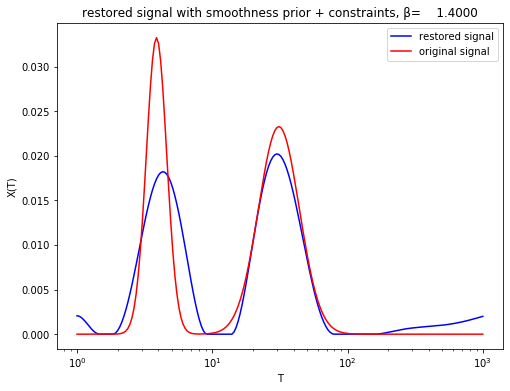

In [16]:
#restored_signal_constraint = proj_grad(x_0, 1e-06, minimum)
restored_signal_constraint = proj_grad(x_0, 1e-06, 0.8)
plt.rcParams['figure.figsize'] = [8, 6]
plt.figure()
plt.plot(T, restored_signal_constraint, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with smoothness prior + constraints, \u03B2={:10.4f}'.format(minimum))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

error_constraint = normalized_quadratic_error(restored_signal_constraint)
print('error = {:9.8f} with \u03B2={}'.format(error_constraint, beta))


* ###  Case 3: **Sparsity prior**
Let
$$g(x) = \frac{1}{2} \lVert x \rVert_1$$
Our problem is to find
$$ \underset{x \in \mathbb{R}^N}{\arg\min}
\frac{1}{2} \left\lVert Kx - y \right\rVert ^2 +  \frac{\beta}{2} \lVert x \rVert_1$$

#### 1. Discuss the existence and uniqueness of a solution to the problem:

Let $f(x) := \frac{1}{2} \left\lVert Kx - y \right\rVert ^2 +  \frac{\beta}{2} \lVert x \rVert_1$. The function $x \mapsto \lVert x \rVert_1$ is clearly in $\Gamma_0$ and $\beta$ is positive, so $f \in \Gamma_0$ because the matrix $K^T K  \succeq 0$. 

* if $\beta =0$, the problem is just a least-squares minimization problem and $\hat{x}$ is an optimum if and only if 
$\hat{x} =(K^T K )^{-1} K^T y $. The uniqueness of such an optimum is obtained when $K^T K$ is non singular. 

* if $\beta > 0$, then $ x \mapsto \frac{\beta}{2} \lVert x \rVert_1$ is coercive. So $f$ is coercice because $\frac{1}{2} \left\lVert Kx - y \right\rVert ^2$ is positive. As $f \in \Gamma_0$ is coercice, there exists $\hat{x} \in \mathbb{R}^N$ such that $f(\hat{x}) = \inf_{x\in \mathbb{R}^N} f(x)$. As $ x \mapsto \frac{\beta}{2} \lVert x \rVert_1$ is strictly convex and $x \mapsto \frac{1}{2} \left\lVert Kx - y \right\rVert ^2$ is convex, $f$ is strictly convex. So the optimum is unique.

#### 2. Propose an approach to solve the problem：

*Forward-Backward algorithm* would be a suitable choice because $ x \mapsto \frac{\beta}{2} \lVert x \rVert_1 \in \Gamma_0$ and $x \mapsto \frac{1}{2} \left\lVert Kx - y \right\rVert ^2 \in \Gamma_0$ is differentiable with a $\nu$-Lipschitzian gradient where $ \nu >0$ is the maximal absolute eigenvalue of $K^T K$.

#### 3. Implement it, and display the restored signal $\bar{x}$:

I implement here a forward backward algorithm with a line search routine to find the best $\lambda$ in each update.

In [17]:
Y_SQUARE = y @ y

def prox(Chi, ksi):
    """Prox of Chi * norm_1(ksi). Note that ksi could be a vector."""
    return np.sign(ksi) * np.maximum(np.abs(ksi) - Chi, 0)

def relative_change(x, x_new):
    return linalg.norm(x_new-x, ord = np.inf) / linalg.norm(x, ord = np.inf)

def forward_backward(x_0, beta, EPSILON = 1e-6, MAX_ITER = int(1e6)):
    def grad(x):
        """Gradient of differential part."""
        return K_SQUARE @ x - KY
    
    nu = np.max(np.abs(linalg.eigvals(K_SQUARE)))
    gamma = 2/nu * 0.98
    delta = 2 - gamma * nu/2
    
    def line_search(x, prox_y):
        # je fais expres de ne pas utiliser de boucle en python
        lamb_candidate = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 1])
        Lambda = lamb_candidate * 0.98 * gamma
        Lambda = np.tile(Lambda, (N,1)).T
        X = np.tile(x, (lamb_candidate.size, 1))
        X_candidate = X + Lambda * (prox_y - x)
#         print(X_candidate)
#         breakpoint()
        f_X_candidate = 1/2 * np.einsum('ij,ji->i', X_candidate @ K_SQUARE, X_candidate.T) 
#         breakpoint()
        f_X_candidate -= X_candidate @ KY 
        f_X_candidate += 1/2*Y_SQUARE 
        f_X_candidate += beta/2 * linalg.norm(X_candidate, ord=1, axis=1) #np.sum(np.abs(X_candidate), axis = 1)             #linalg.norm(X_candidate, ord=1, axis=1)
        
        minimum_x = X_candidate[np.argmin(f_X_candidate)]
#         print("lambda = {}".format(lamb_candidate[np.argmin(f_X_candidate)]))
        return minimum_x
#         def f():
#             return 1/2 * (x @ K_SQUARE @ x + y @ y ) - x @ KY + beta/2 * linalg.norm(x, ord =1)
    
    x_change_rate = 1
    x = x_0
    for _ in range(MAX_ITER): #tqdm(range(MAX_ITER)):
        x_old = x
        y = x - gamma * grad(x)
        prox_y = prox(gamma * beta/2, y)
        x = line_search(x, prox_y)
        x_change_rate = relative_change(x_old, x)
        if x_change_rate < EPSILON:
            return x
    print('max iteration {} reached, relative change in norm of x is {}'.format(MAX_ITER, x_change_rate))
    return x

#     counter = 0
#     while x_change_rate > EPSILON:
#         if counter > MAX_ITER:
#             print('max iteration {} reached, relative change in norm of x is {}'.format(MAX_ITER, x_change_rate))
#             return x
#         x_old = x
#         y = x - gamma * grad(x)
#         prox_y = prox(gamma * beta/2, y)
#         x = line_search(x, prox_y)
#         x_change_rate = relative_change(x_old, x)
#         counter += 1
#         print("relative change = {}".format(x_change_rate))
    return x

max iteration 1000000 reached, relative change in norm of x is 4.015218368530591e-05
max iteration 1000000 reached, relative change in norm of x is 4.0152183685298936e-05


NameError: name 'restored_signal_sparse_1' is not defined

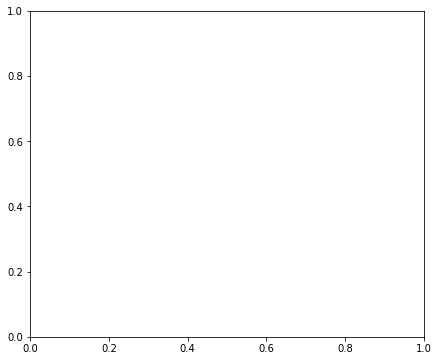

In [18]:
restored_signal_sparse_10 = forward_backward(x_0, 10)
restored_signal_sparse_100 = forward_backward(x_0, 100)


plt.rcParams['figure.figsize'] = [24, 6]

plt.figure()
plt.subplot(1, 3, 1)
plt.plot(T, restored_signal_sparse_1, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal sparse, \u03B2={}'.format(1))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 2)
plt.plot(T, restored_signal_sparse_10,'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal sparse, \u03B2={}'.format(10))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

plt.subplot(1, 3, 3)
plt.plot(T, restored_signal_sparse_100,'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal sparse, \u03B2={}'.format(100))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

When $\beta$ is too big ($>10$), the regularization is so strong that the restored signal is zero.

#### 4. Compute the normalized quadratic error between $\hat{x}$ and $\bar{x}$.

We show the normalized quadratic error with $\beta = 1, \beta = 10, \beta = 100$ in this question.

In [35]:
def normalized_quadratic_error(restored_signal):
    x_hat_square = np.dot(restored_signal, restored_signal)
    return (x_hat_square -2 * np.dot(original_signal, restored_signal) + X_BAR_SQUARE) / X_BAR_SQUARE

error_sparse_1 = normalized_quadratic_error(restored_signal_sparse_1)
print('error = {:9.8f} with \u03B2={}'.format(error_sparse_1, 1))

error_sparse_10 = normalized_quadratic_error(restored_signal_sparse_10)
print('error = {:9.8f} with \u03B2={}'.format(error_sparse_10, 10))

error_sparse_100 = normalized_quadratic_error(restored_signal_sparse_100)
print('error = {:9.8f} with \u03B2={}'.format(error_sparse_100, 100))

error = 0.57042918 with β=1
error = 1.00000000 with β=10
error = 1.00000000 with β=100


#### 5. When needed, search manually for the best choice for parameter $\beta$ in terms of reconstruction error.

Unfortunately, it is too long to be done in large range.

In [40]:
def error_sparse_beta(beta):
    restored_signal_sparse = forward_backward(x_0, beta)
    print('beta = {} ok'.format(beta))
    error_sparse = normalized_quadratic_error(restored_signal_sparse)
    return error_sparse

# error_sparse_beta = np.vectorize(error_sparse_beta)

Beta = np.linspace(0.1, 5, 10)
Error_sparse = []
for beta in Beta:
    error = error_sparse_beta(beta)
    print("error = {} for beta = {}".format(error, beta))
    Error_sparse.append(error)
# Error_sparse = error_sparse_beta(Beta)

beta = 0.1 ok
error = 0.002375218408833375 for beta = 0.1
beta = 0.6444444444444445 ok
error = 0.4707196587858177 for beta = 0.6444444444444445
beta = 1.188888888888889 ok
error = 0.5300098926014101 for beta = 1.188888888888889
beta = 1.7333333333333336 ok
error = 0.6042658167291141 for beta = 1.7333333333333336
beta = 2.277777777777778 ok
error = 1.144435935081174 for beta = 2.277777777777778
beta = 2.8222222222222224 ok
error = 1.3554936925901475 for beta = 2.8222222222222224
beta = 3.366666666666667 ok
error = 1.263992583604669 for beta = 3.366666666666667
beta = 3.911111111111112 ok
error = 1.1786440277006167 for beta = 3.911111111111112
beta = 4.455555555555556 ok
error = 1.110713853915996 for beta = 4.455555555555556
beta = 5.0 ok
error = 1.1252648863122672 for beta = 5.0


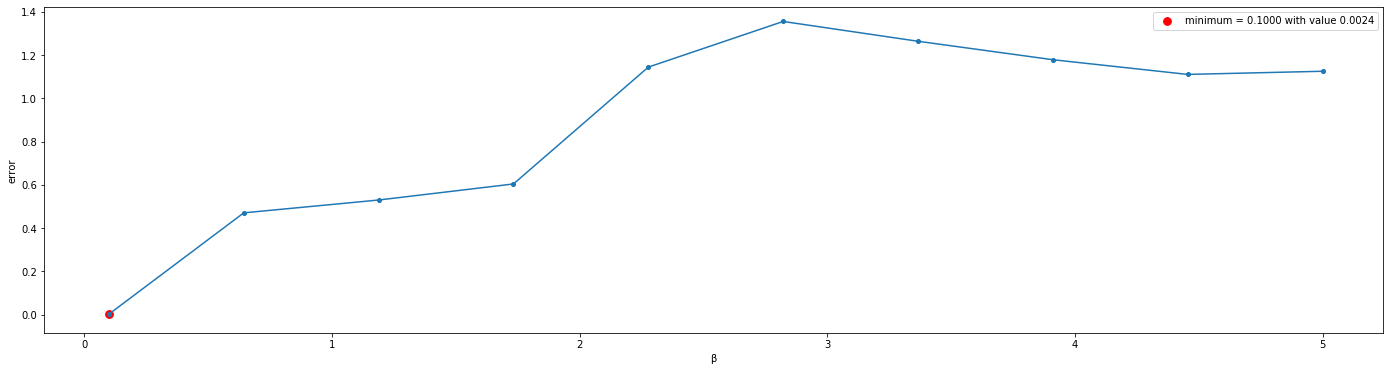

In [41]:
plt.plot(Beta[:len(Error_sparse)], Error_sparse, 'o-', markersize=4)
plt.xlabel('\u03B2')
plt.ylabel('error');

min_index = np.argmin(Error_sparse)
minimum = Beta[min_index]
min_val = Error_sparse[min_index]

plt.scatter(minimum, min_val, s= 60, c = 'red', label = 'minimum = {:5.4f} with value {:5.4f}'.format(minimum, min_val))
plt.legend();

error = 0.00397634 with β=1.4000000000000001


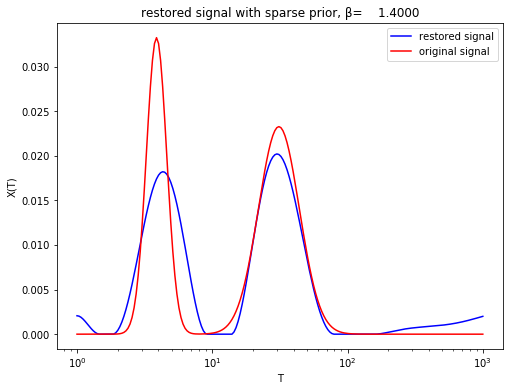

In [20]:
#restored_signal_sparse = forward_backward(x_0, minimum)
restored_signal_sparse = forward_backward(x_0, 0.1)
plt.rcParams['figure.figsize'] = [8, 6]
plt.figure()
plt.plot(T, restored_signal_constraint, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with sparse prior, \u03B2={:10.4f}'.format(minimum))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

error_sparse = normalized_quadratic_error(restored_signal_sparse)
print('error = {:9.8f} with \u03B2={}'.format(error_sparse, beta))

#### Conclusion:

In this case, the minimal error with sparse prior is 0.002  which is better than the "smoothness prior + constraints" case whose error is 0.0768 and the smooth prior case whose error is 0.4544.